## The one-sector system 

For our optimation analysis, we are going to consider a particular case of the SEIR* model which models the spread of covid-19 in a number $n$ of sectors. So if we fix $n=1$ we obtain the following one-sector system. 

\begin{eqnarray*}
\frac{dS}{dt} &=& - \beta\, K_{s}\, S \,(\alpha(t) \, p) \, \frac{I}{N} \, (\epsilon \, K_{s} + (1-\epsilon)\, K_{i}) \, ,\\
\frac{dE}{dt} &=& - \beta \, K_{s} \, S \, (\alpha(t) \, p) \, \frac{I}{N} \, (\epsilon \, K_{s} + (1-\epsilon)\, K_{i}) - \sigma \, E \, ,\\
\frac{dI}{dt} & = & \sigma E - \gamma \, I \, ,\\
\frac{dR}{dt} & = & \gamma I \, ,
\end{eqnarray*}

where the parameters $\beta$, $\sigma$, $\gamma$, $K_{s}$, $\alpha$, $p$, $\epsilon$, $K_{i}$ are defined as:

\begin{eqnarray*}
\beta &:=& \text{Intrinsic rate infection}.\\
\sigma^{-1} &:=& \text{Expected incubation period}.\\
\gamma^{-1} &:=& \text{Expected recovery time}.\\
p &:=& \text{Proportion of inhabitants that stays at their own sector before pandemic*}. (p=1)\\
\alpha &:=& \text{Regular variations of inhabitants proportion*}. (\alpha = 1)\\
K_{s} &:=& \text{Average risk reduction of suceptible inhabitants due to safety measures}.\\
K_{i} &:=& \text{Average risk reduction of infected inhabitants due to either self-seclusion or hospitalization}.\\
\epsilon &:=& \text{Proportion of infected asymptomatic inhabitants}.
\end{eqnarray*}



$\underline{NOTA:}$ Note that if the parameter $\epsilon$, $K_{s}$, $K_{i}$, $p$, $\alpha$ are equal to one then the previous system of equations reduces to the classical system of equations of the SEIR model.

$*$ In the case one-sector SEIR* model $\alpha =1$ and $p=1$

### Class SEIR and solve_ivp.

solve_ivp is a method of sub.package of integration scipy.integrate which is used to solve systems of ordinary differential equations given an initial value.

In [62]:
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 24 10:55:47 2020

@author: abarr
"""

import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import expit
from joblib import Parallel, delayed
from scipy import signal
import pandas as pd 
from numpy import linalg as LA 
import multiprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class SEIR_:
    
    def __init__(self, P, alpha, S0, E0, I0, R0, beta, sigma, gamma, mu, epsilon, Ks, Ki):
        
        self.S=S0
        self.E=E0
        self.I=I0
        self.R=R0
        self.N=(S0+E0+I0+R0).astype("float64")
        self.P=P
        
        self.population=population
        self.tsim=tsim
        
        self.alpha=alpha
        
        self.beta=beta
        self.gamma=gamma
        self.sigma=sigma
        self.mu=mu
        self.epsilon=epsilon
        self.Ks=Ks
        self.Ki=Ki
        
        self.dSdt = lambda t,S,I: -self.beta*Ks*np.diag(np.reciprocal(self.N_hat(P, self.N, alpha, t))*S).dot(self.P_hat(P, alpha, t)).dot(self.I_hat(P, I, epsilon, Ks, Ki, alpha, t))
        self.dEdt = lambda t,S,I,E: self.beta*Ks*np.diag(np.reciprocal(self.N_hat(P, self.N, alpha, t))*S).dot(self.P_hat(P, alpha, t)).dot(self.I_hat(P, I, epsilon, Ks, Ki, alpha, t)) - self.sigma*E;
        self.dIdt = lambda t,E,I: self.sigma*E - self.gamma*I;
        self.dRdt = lambda t,I: self.gamma*I;
        
    def P_hat(self, P, alpha, t):
        return(alpha(t)*P)

    def I_hat(self, P, I, epsilon, Ks, Ki, alpha, t):
        return (epsilon*Ks+(1-epsilon)*Ki) * self.P_hat(P, alpha, t).T.dot(I)

    def N_hat(self, P, N, alpha, t):
        return(self.P_hat(P, alpha, t).T.dot(N)) # dim(N)=34
    
    
    
    def integr_sci(self, t0, T, h, E0init=False):
        
        self.t=np.arange(t0,T+h,h)
        
        def model_SEIR_graph(t,y):
         
            ydot=np.zeros(len(y))
            
            ydot[0]=self.dSdt(t,y[0],y[2])
            ydot[1]=self.dEdt(t,y[0],y[2],y[1])
            ydot[2]=self.dIdt(t,y[1],y[2])
            ydot[3]=self.dRdt(t,y[2])
            
            return(ydot)
            
        initcond = (S0,E0,I0,R0)
        
        sol = solve_ivp(model_SEIR_graph,(t0,T), initcond, method='LSODA', t_eval=self.t)
             
        return(sol)

### Only one Testing. 

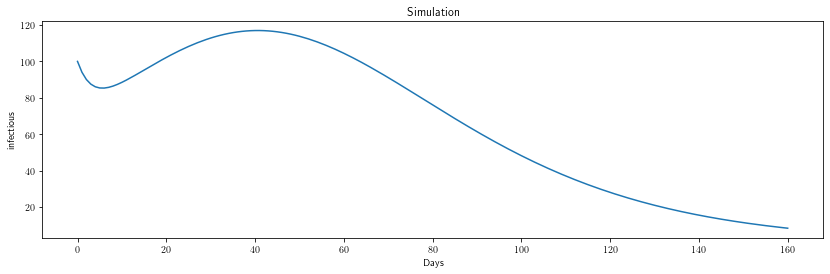

In [94]:

def alpha(t):
    return(np.ones(1))

S0 = np.array(1000)
E0 = np.array(0)
I0 = np.array(100)
R0 = np.array(0)

N=S0+E0+I0+R0

#fixing parameters values
mu=0
beta=0.380
sigma=1/5
gamma=1/14

epsilon=0.3
Ks=0.9
Ki=0.1

Par_r=[Ks,Ki]

P=1
tsim=160

test_ = SEIR_(P, alpha, S0, E0, I0, R0, beta, sigma, gamma, mu, epsilon, Ks, Ki)

t0=0
h=1
sol=test_.integr_sci(t0,tsim,h,E0init=False)
S,E,I,R=sol.y
t=sol.t
t=np.arange(t0,tsim+h,h)
plt.rcParams["figure.figsize"] = 14, 4
plt.plot(t,I)
#plt.plot(test_s.I[0])
plt.xlabel('Days')
plt.ylabel('infectious')
plt.title('Simulation')
#plt.legend(bbox_to_anchor=(0.5,-0.2), loc="upper center", fancybox=True, shadow=True, ncol=5)

plt.show()

In [64]:
# Import data

path = "C:\\Users\\abarr\\Documents\\GitHub\\covid19geomodeller\\Examples\\One-sector optimization\\Datos\\"
dat_syn = pd.read_csv(path+"infected_active.csv")['node 0']

print(dat_syn)

0      100.000000
1       94.048525
2       90.058743
3       87.525139
4       86.072426
          ...    
155      9.839170
156      9.538931
157      9.247497
158      8.964632
159      8.690106
Name: node 0, Length: 160, dtype: float64


### Fixed mobility and variable entropy.

* Optimized parameters: $K_s$, $K_i$.
* The synthetic data of active infected were obtained with the following values of the parameters: $\mu=0$, $\beta=0.380$, $\sigma=1/5$, $\gamma=1/14$, $\epsilon=0.3$, $K_s=0.9$, $K_i=0.1$, $p=1$, $\alpha=1$, and the following initial conditions $S(t_{0})= 1000$, $E(t_{0})=0$, $I(t_{0})=100$, $R(t_{0})=0$. 
* Simulation time is 160 days.
* Objective function: $f=\Delta_{t}+\Delta_{I}+\Delta_{s}$.
  * $\Delta_{I}=|I_s(t_p^s)-I_d(t_p^d)|$ where $I_d$ and $I_s$ are data and simulated time-series of infected people respectively. 
 
  * The time interval $\Delta_{t}=|t_p^s-t_p^d|$ between the data infection peak time $t_p^d$ and the simulated infection peak time $t_p^s$.
  
  * The difference $\Delta_{s}=\left|\displaystyle\int_{t=0}^{t_{max}} I_s(t)dt-\sum_{t=0}^{t_{max}}I_d(t) \right|$ where $t_{max}$ is the last available day with data.

* Optimization method: PSO.


In [113]:
import sys
from pathlib import Path
sys.path.insert(1, '../src/SEIR/')
sys.path.insert(1, '../src/utils/')

from datetime import datetime
import numpy as np
from numpy import linalg as LA
import pygmo as pg
import pandas as pd
from time import time

import numpy as np
from scipy.integrate import simps
from numpy import trapz

class SEIRoptimization:
    def __init__(self,P,S0,E0,I0,R0,mu,beta,sigma,gamma,epsilon,Ir,alpha,bounds): 
                    
        self.Ir=Ir
        self.alpha=alpha
        self.bounds=bounds
        self.P=P
        self.S0=S0
        self.E0=E0
        self.I0=I0
        self.R0=R0
        self.mu=mu
        self.beta=beta
        self.sigma=sigma
        self.gamma=gamma
        self.epsilon=epsilon
    
    def fitness(self,x):
        test_ = SEIR_(P=self.P, alpha=self.alpha, S0=self.S0, E0=self.E0, I0=self.I0, R0=self.R0, beta=self.beta, sigma=self.sigma, gamma=self.gamma, mu=self.mu, epsilon=self.epsilon, Ks=x[0], Ki=x[1])
        sol=test_.integr_sci(0,tsim,1,E0init=False)
        
        Data_=pd.DataFrame(sol.y[2])
        Data_.index=sol.t
        Data_.columns=['infecciosos']
        x=Data_[Data_.infecciosos==max(Data_['infecciosos'])]
        vec_s=[x.index[0], x['infecciosos'].values[0]]
        
        Dat_=pd.DataFrame(Ir)
        Dat_.columns=['Infec_reales']
        y=Dat_[Dat_.Infec_reales==max(Dat_['Infec_reales'])]
        vec_r=[y.index[0], y['Infec_reales'].values[0]]
        # 0*vec_s[0]-vec_r[0]) + 0*np.abs(vec_s[1]-vec_r[1])
        res=np.abs(vec_s[0]-vec_r[0]) + np.abs(vec_s[1]-vec_r[1]) + np.abs(trapz(self.Ir,dx=1)-trapz(sol.y[2], dx=1))
                   
        return [res]
    
    def get_bounds(self):
        return(self.bounds)
    
    def set_bounds(self,bounds):
        self.bounds = bounds
        return(self.bounds)

In [114]:
# parameters to optimize
# Ks, Ki
lb=[0.0, 0.0]
ub=[1, 1]

bounds = [lb,ub]
Ir=dat_syn.values

##########
S0 = np.array(1000)
E0 = np.array(0)
I0 = np.array(100)
R0 = np.array(0)

N=S0+E0+I0+R0

mu=0
beta=0.380
sigma=1/5
gamma=1/14

epsilon=0.3
P=1
##########
#pygmo optimization object
opti=SEIRoptimization(P,S0,E0,I0,R0,mu,beta,sigma,gamma,epsilon,Ir,alpha,bounds)               
algo = pg.algorithm(pg.pso(gen = 50))
pop = pg.population(opti,80)

## Muestra quien gano
t0 = time()
pop = algo.evolve(pop)
t1 = time()
print('Optimization takes %f seconds' %(t1-t0))
print('Fitness Value')
print(pop.champion_f)
print('Optimal arguments')
print(pop.champion_x)

## Guarda al ganador 
Par_opt=pop.champion_x


Optimization takes 45.522338 seconds
Fitness Value
[0.08823227]
Optimal arguments
[1.         0.00838556]


### Solving the one-sector system with the winning parameters.

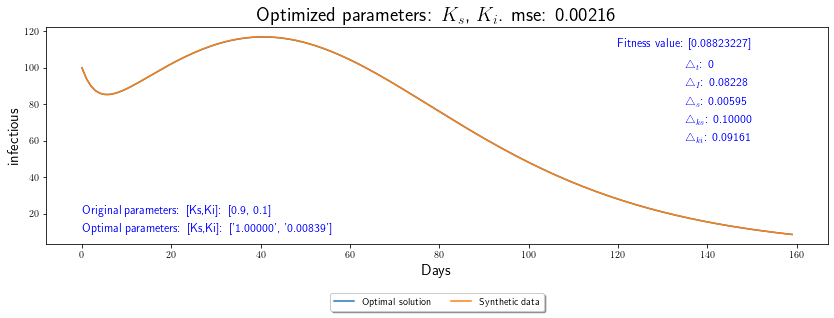

In [115]:

def alpha(t):
    return(np.ones(1))

S0 = np.array(1000)
E0 = np.array(0)
I0 = np.array(100)
R0 = np.array(0)

N=S0+E0+I0+R0

#fixing parameters values
mu=0
beta=0.380
sigma=1/5
gamma=1/14

epsilon=0.3
Ks=Par_opt[0]
Ki=Par_opt[1]

P=1
tsim=159
population=N
test_ = SEIR_(P, alpha, S0, E0, I0, R0, beta, sigma, gamma, mu, epsilon, Ks, Ki)
t0=0
h=1
sol=test_.integr_sci(t0,tsim,h,E0init=False)
S,E,I,R=sol.y
t=sol.t

#######
mse = mean_squared_error(Ir,I)
######

Data_=pd.DataFrame(I)
Data_.index=sol.t
Data_.columns=['infecciosos']
x=Data_[Data_.infecciosos==max(Data_['infecciosos'])]
vec_s=[x.index[0], x['infecciosos'].values[0]]

Dat_=pd.DataFrame(Ir)
Dat_.columns=['Infec_reales']
y=Dat_[Dat_.Infec_reales==max(Dat_['Infec_reales'])]
vec_r=[y.index[0], y['Infec_reales'].values[0]]

delta_t=np.abs(vec_s[0]-vec_r[0])
delta_I=np.abs(vec_s[1]-vec_r[1])
delta_s=np.abs(trapz(Ir,dx=1)-trapz(I,dx=1))

delta_ks=np.abs(Par_opt[0]-Par_r[0])
delta_ki=np.abs(Par_opt[1]-Par_r[1])

plt.rc('text', usetex=True)
plt.rcParams["figure.figsize"] = 14, 4
plt.plot(t,I, label='Optimal solution')
plt.plot(t,Ir, label='Synthetic data')
#plt.plot(Datos_activos_interp[comunas[12]].values , label=comunas[12])
#plt.plot(t,test.I[num_test], label='Infected')
#plt.plot(test.R[num_test], label='Removed') 
plt.xlabel('Days',size=15)
plt.ylabel('infectious',size=15)
plt.title('Optimized parameters: $K_s$, $K_i$. ' + 'mse: ' + str("{:.5f}".format(mse)),size=20)
plt.legend(bbox_to_anchor=(0.5,-0.2), loc="upper center", fancybox=True, shadow=True, ncol=5)
plt.text(135, 110, 'Fitness value: ' + str(pop.champion_f) , {'color': 'b','fontsize': 12},
    ha='center', va='bottom') 
plt.text(135, 100, r'$\bigtriangleup_{t}$: ' + str(delta_t), {'color': 'b','fontsize': 12})
plt.text(135, 90, r'$\bigtriangleup_{I}$: ' + str("{:.5f}".format(delta_I)), {'color': 'b','fontsize': 12})
plt.text(135, 80, r'$\bigtriangleup_{s}$: ' + str("{:.5f}".format(delta_s)), {'color': 'b','fontsize': 12})
plt.text(135, 70, r'$\bigtriangleup_{ks}$: ' + str("{:.5f}".format(delta_ks)), {'color': 'b','fontsize': 12})
plt.text(135, 60, r'$\bigtriangleup_{ki}$: ' + str("{:.5f}".format(delta_ki)), {'color': 'b','fontsize': 12})

plt.text(0, 20, r'Original parameters: [Ks,Ki]: ' + str([Par_r[0],Par_r[1]]), {'color': 'b','fontsize': 12})
plt.text(0, 10, r'Optimal parameters: [Ks,Ki]: ' + str([str("{:.5f}".format(Par_opt[0])),'{:.5f}'.format(Par_opt[1])]), {'color': 'b','fontsize': 12})

plt.show()


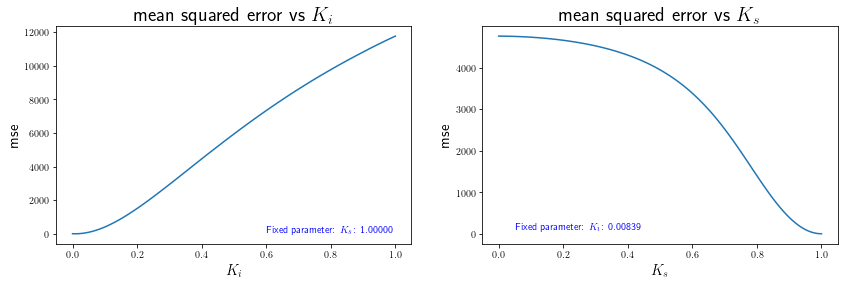

In [116]:
### mse plot versus variable entropy
h=0.01
vec_ks=np.arange(0,1+h,h)
vec_ki=np.arange(0,1+h,h)
#vec_ki=np.flip(vec_ki)

#### inicial conditions
def alpha(t):
    return(np.ones(1))

S0 = np.array(1000)
E0 = np.array(0)
I0 = np.array(100)
R0 = np.array(0)

N=S0+E0+I0+R0

#fixing parameters values
mu=0
beta=0.380
sigma=1/5
gamma=1/14

epsilon=0.3
P=1
tsim=159
population=N
t0=0
h=1
ecm_ks=pd.DataFrame(columns=['mse'])
for i in range(len(vec_ki)):
    Ks=Par_opt[0]
    Ki=vec_ki[i]
    test_ = SEIR_(P, alpha, S0, E0, I0, R0, beta, sigma, gamma, mu, epsilon, Ks, Ki)
    sol=test_.integr_sci(t0,tsim,h,E0init=False)
    S,E,I,R=sol.y
    mse = mean_squared_error(Ir,I)
    ecm_ks.loc[i]=mse

ecm_ki=pd.DataFrame(columns=['mse'])
for i in range(len(vec_ki)):
    Ks=vec_ks[i]
    Ki=Par_opt[1]
    test_ = SEIR_(P, alpha, S0, E0, I0, R0, beta, sigma, gamma, mu, epsilon, Ks, Ki)
    sol=test_.integr_sci(t0,tsim,h,E0init=False)
    S,E,I,R=sol.y
    mse = mean_squared_error(Ir,I)
    ecm_ki.loc[i]=mse
    

# Plot
plt.rcParams["figure.figsize"] = 14, 4

# Mobility matrix
plt.subplot(1,2,1)
plt.plot(vec_ki,ecm_ks['mse'].values)
plt.title("mean squared error vs $K_i$", size=20)
plt.xlabel("$K_i$", size=15)
plt.ylabel("mse", size=15)
plt.text(0.6, 100, r'Fixed parameter: $K_s$: ' + str("{:.5f}".format(Par_opt[0])), {'color': 'b','fontsize': 10})

# Destination
plt.subplot(1,2,2)
plt.plot(vec_ks,ecm_ki['mse'].values)
plt.title("mean squared error vs $K_s$", size=20)
plt.xlabel("$K_s$", size=15)
plt.ylabel("mse", size=15)
plt.text(0.05, 100, r'Fixed parameter: $K_i$: ' + str("{:.5f}".format(Par_opt[1])), {'color': 'b','fontsize': 10})
plt.show()
